# Image Super-Resolution using an Efficient Sub-Pixel CNN

**Author:** [Pritom Mojumder](https://github.com/ipritom)<br>
**Date created:** 2021/08/20<br>
**Description:** Implementing Super-Resolution using Efficient sub-pixel model on DIV2K.

## Introduction

ESPCN (Efficient Sub-Pixel CNN), proposed by [Shi, 2016](https://arxiv.org/abs/1609.05158)
is a model that reconstructs a high-resolution version of an image given a low-resolution version.
It leverages efficient "sub-pixel convolution" layers, which learns an array of
image upscaling filters.

In this project  DIV2K dataset have been utilised which has 800 high resolution images.
[DIV2K](https://data.vision.ee.ethz.ch/cvl/DIV2K/).

In [ ]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Loading 
In this project DIV2K dataset have been utilised which has 800 high resolution images

In [ ]:
dataset_url = "/content/drive/MyDrive/Project/DIV2Kpc/target/output"
# data_dir = dataset_url
#root_dir = os.path.join(data_dir, "BSDS500/data")

In [ ]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    dataset_url,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    dataset_url,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 800 files belonging to 1 classes.
Using 640 files for training.
Found 800 files belonging to 1 classes.
Using 160 files for validation.


In [ ]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

In [ ]:
# for batch in train_ds.take(1):
#     for img in batch:
#         display(array_to_img(img))

In [ ]:
#dataset = os.path.join(dataset_url, "//")
# test_path = os.path.join(dataset_url, "test")

test_img_paths = sorted(
    [
        os.path.join(dataset_url, fname)
        for fname in os.listdir(dataset_url)
        if fname.endswith(".png") #set image filename extensionn
    ]
)

In [ ]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

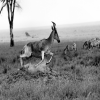

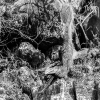

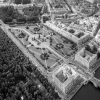

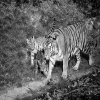

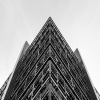

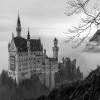

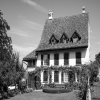

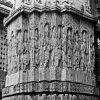

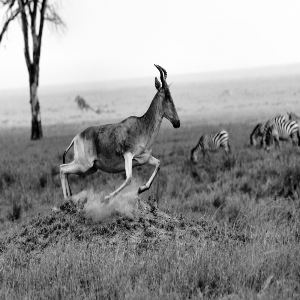

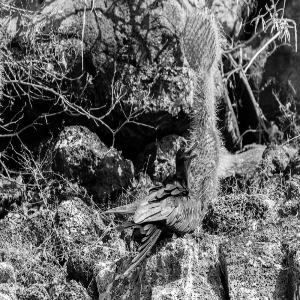

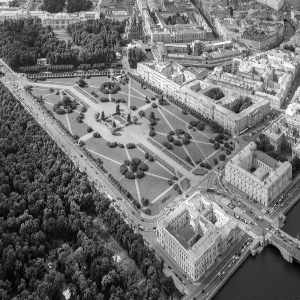

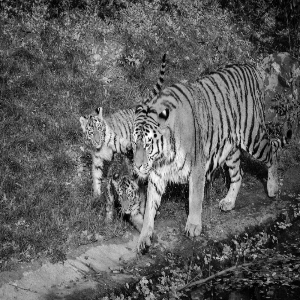

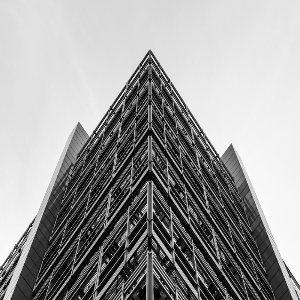

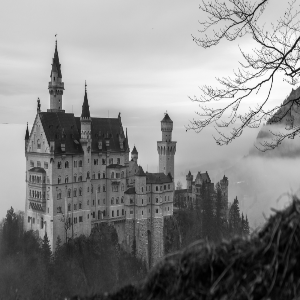

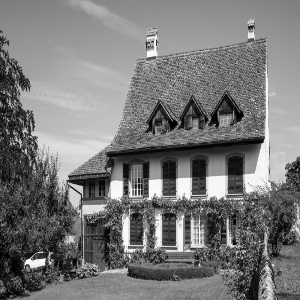

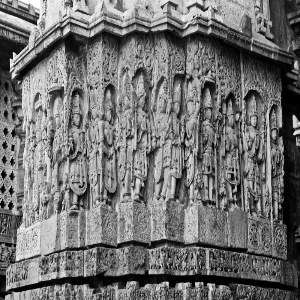

In [ ]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

# Build ESPCNN model 

In [ ]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 7, **conv_args)(inputs)
    x = layers.Conv2D(64, 5, **conv_args)(x)
    x = layers.Conv2D(64, 3, **conv_args)(x) #extra layer
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


## Define utility functions

We need to define several utility functions to monitor our results:

- `plot_results` to plot an save an image.
- `get_lowres_image` to convert an image to its low-resolution version.
- `upscale_image` to turn a low-resolution image to
a high-resolution version reconstructed by the model.
In this function, we use the `y` channel from the YUV color space
as input to the model and then combine the output with the
other channels to obtain an RGB image.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


## Define callbacks to monitor training

The `ESPCNCallback` object will compute and display
the [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) metric.
This is the main metric we use to evaluate super-resolution performance.

In [ ]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)    3200      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 64)    102464    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space_1 (TFOp (None, None, None, 1)     0   

# Train the model

Epoch 1/100
80/80 - 305s - loss: 0.0274 - val_loss: 0.0094
Mean PSNR for epoch: 19.96


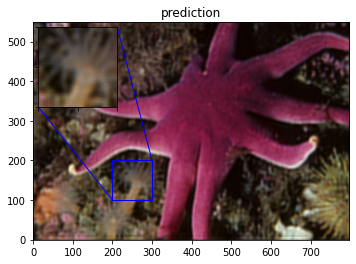

Epoch 2/100
80/80 - 12s - loss: 0.0069 - val_loss: 0.0054
Mean PSNR for epoch: 22.58
Epoch 3/100
80/80 - 12s - loss: 0.0053 - val_loss: 0.0046
Mean PSNR for epoch: 23.22
Epoch 4/100
80/80 - 11s - loss: 0.0050 - val_loss: 0.0045
Mean PSNR for epoch: 23.25
Epoch 5/100
80/80 - 12s - loss: 0.0049 - val_loss: 0.0044
Mean PSNR for epoch: 23.50
Epoch 6/100
80/80 - 12s - loss: 0.0050 - val_loss: 0.0044
Mean PSNR for epoch: 23.38
Epoch 7/100
80/80 - 12s - loss: 0.0047 - val_loss: 0.0043
Mean PSNR for epoch: 23.58
Epoch 8/100
80/80 - 12s - loss: 0.0047 - val_loss: 0.0042
Mean PSNR for epoch: 23.48
Epoch 9/100
80/80 - 12s - loss: 0.0048 - val_loss: 0.0043
Mean PSNR for epoch: 23.43
Epoch 10/100
80/80 - 12s - loss: 0.0050 - val_loss: 0.0061
Mean PSNR for epoch: 22.12
Epoch 11/100
80/80 - 12s - loss: 0.0051 - val_loss: 0.0042
Mean PSNR for epoch: 23.50
Epoch 12/100
80/80 - 12s - loss: 0.0046 - val_loss: 0.0042
Mean PSNR for epoch: 23.44
Epoch 13/100
80/80 - 11s - loss: 0.0046 - val_loss: 0.0042
Mea

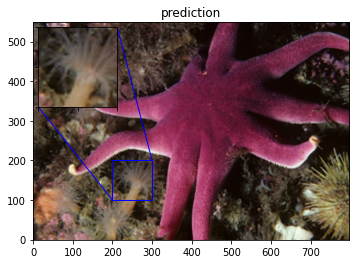

Epoch 22/100
80/80 - 11s - loss: 0.0046 - val_loss: 0.0041
Mean PSNR for epoch: 23.67
Epoch 23/100
80/80 - 11s - loss: 0.0045 - val_loss: 0.0041
Mean PSNR for epoch: 23.42
Epoch 24/100
80/80 - 12s - loss: 0.0046 - val_loss: 0.0043
Mean PSNR for epoch: 23.80
Epoch 25/100
80/80 - 11s - loss: 0.0051 - val_loss: 0.0041
Mean PSNR for epoch: 24.03
Epoch 26/100
80/80 - 11s - loss: 0.0045 - val_loss: 0.0040
Mean PSNR for epoch: 23.81
Epoch 27/100
80/80 - 11s - loss: 0.0045 - val_loss: 0.0040
Mean PSNR for epoch: 23.95
Epoch 28/100
80/80 - 11s - loss: 0.0045 - val_loss: 0.0041
Mean PSNR for epoch: 23.88
Epoch 29/100
80/80 - 11s - loss: 0.0044 - val_loss: 0.0040
Mean PSNR for epoch: 23.91
Epoch 30/100
80/80 - 11s - loss: 0.0044 - val_loss: 0.0040
Mean PSNR for epoch: 24.06
Epoch 31/100
80/80 - 12s - loss: 0.0044 - val_loss: 0.0040
Mean PSNR for epoch: 23.78
Epoch 32/100
80/80 - 11s - loss: 0.0048 - val_loss: 0.0041
Mean PSNR for epoch: 23.86
Epoch 33/100
80/80 - 11s - loss: 0.0044 - val_loss: 0.

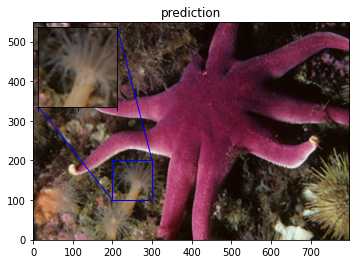

Epoch 42/100
80/80 - 11s - loss: 0.0044 - val_loss: 0.0040
Mean PSNR for epoch: 23.77
Epoch 43/100
80/80 - 11s - loss: 0.0044 - val_loss: 0.0040
Mean PSNR for epoch: 23.96
Epoch 44/100
80/80 - 11s - loss: 0.0044 - val_loss: 0.0040
Mean PSNR for epoch: 24.05
Epoch 45/100
80/80 - 11s - loss: 0.0044 - val_loss: 0.0040
Mean PSNR for epoch: 23.70
Epoch 46/100
80/80 - 11s - loss: 0.0044 - val_loss: 0.0039
Mean PSNR for epoch: 24.00
Epoch 47/100
80/80 - 11s - loss: 0.0044 - val_loss: 0.0039
Mean PSNR for epoch: 23.82
Epoch 48/100
80/80 - 11s - loss: 0.0044 - val_loss: 0.0040
Mean PSNR for epoch: 23.90
Epoch 49/100
80/80 - 11s - loss: 0.0044 - val_loss: 0.0041
Mean PSNR for epoch: 23.86
Epoch 50/100
80/80 - 11s - loss: 0.0045 - val_loss: 0.0052
Mean PSNR for epoch: 22.76
Epoch 51/100
80/80 - 12s - loss: 0.0048 - val_loss: 0.0040
Mean PSNR for epoch: 23.66
Epoch 52/100
80/80 - 12s - loss: 0.0044 - val_loss: 0.0040
Mean PSNR for epoch: 24.24
Epoch 53/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.

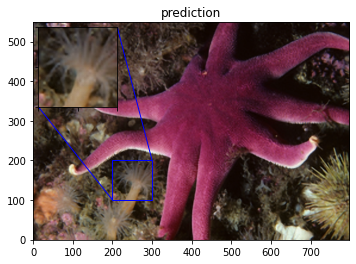

Epoch 62/100
80/80 - 12s - loss: 0.0051 - val_loss: 0.0041
Mean PSNR for epoch: 23.76
Epoch 63/100
80/80 - 12s - loss: 0.0044 - val_loss: 0.0039
Mean PSNR for epoch: 23.48
Epoch 64/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 23.90
Epoch 65/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 23.81
Epoch 66/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 24.10
Epoch 67/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 23.71
Epoch 68/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 23.81
Epoch 69/100
80/80 - 11s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 24.21
Epoch 70/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 23.91
Epoch 71/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 23.80
Epoch 72/100
80/80 - 12s - loss: 0.0045 - val_loss: 0.0039
Mean PSNR for epoch: 23.89
Epoch 73/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.

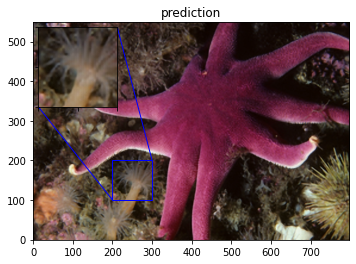

Epoch 82/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 23.77
Epoch 83/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 23.81
Epoch 84/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0040
Mean PSNR for epoch: 24.00
Epoch 85/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 23.78
Epoch 86/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0040
Mean PSNR for epoch: 23.79
Epoch 87/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 23.83
Epoch 88/100
80/80 - 12s - loss: 0.0046 - val_loss: 0.0039
Mean PSNR for epoch: 23.83
Epoch 89/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 23.90
Epoch 90/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 23.57
Epoch 91/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 24.02
Epoch 92/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.0039
Mean PSNR for epoch: 23.69
Epoch 93/100
80/80 - 12s - loss: 0.0043 - val_loss: 0.

In [ ]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

# Model Testing

In [ ]:
project_path = 'drive/MyDrive/Project/'

In [ ]:
sample_img_path = project_path +'low_res_sample2.jpg'

In [ ]:
img = load_img(sample_img_path)

In [ ]:
prediction = upscale_image(model, img)

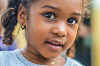

In [ ]:
img

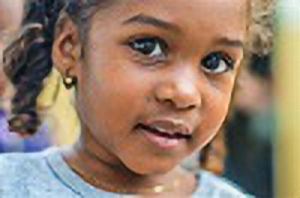

In [ ]:
prediction

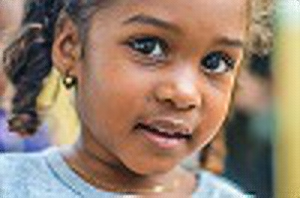

In [ ]:
prediction

PSNR of low resolution image and high resolution image is 26.6134
PSNR of predict and high resolution is 26.9974


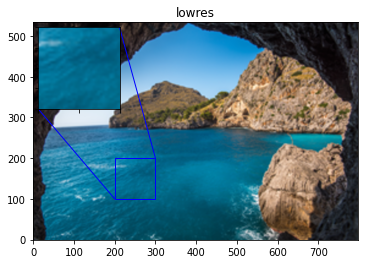

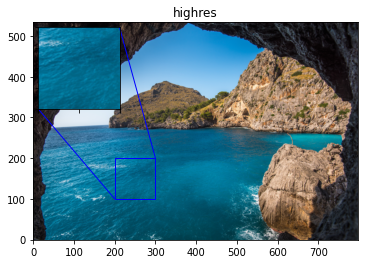

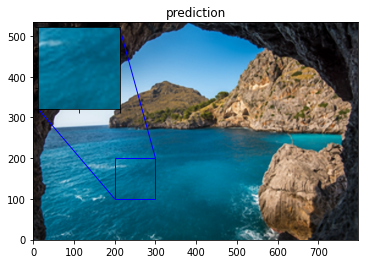

PSNR of low resolution image and high resolution image is 23.1446
PSNR of predict and high resolution is 23.7597


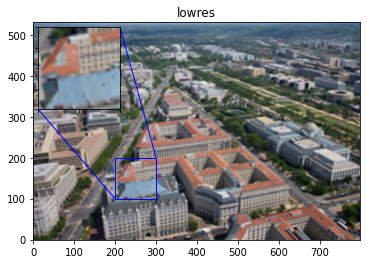

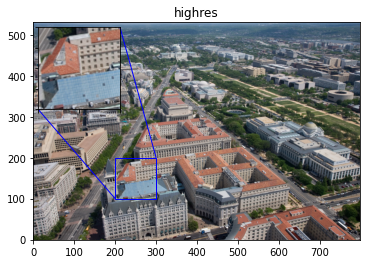

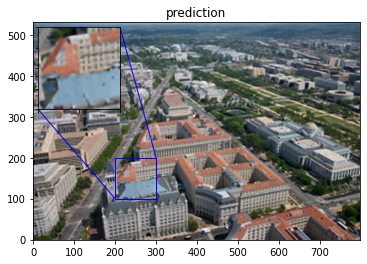

PSNR of low resolution image and high resolution image is 26.9217
PSNR of predict and high resolution is 27.6355


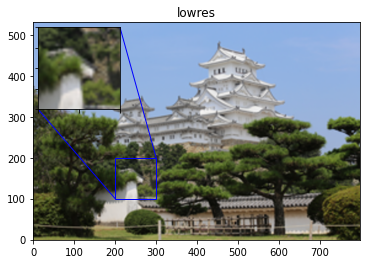

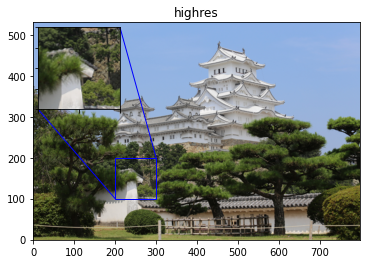

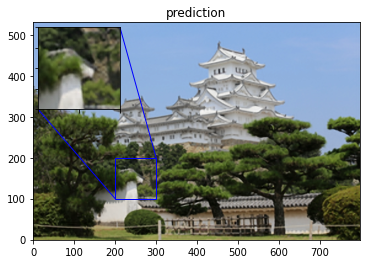

PSNR of low resolution image and high resolution image is 23.6659
PSNR of predict and high resolution is 23.9489


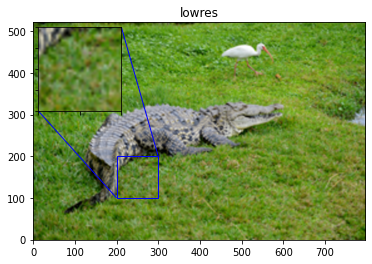

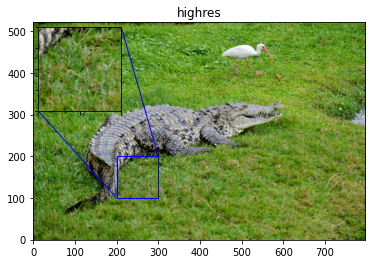

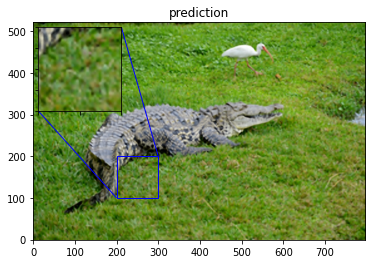

PSNR of low resolution image and high resolution image is 34.2544
PSNR of predict and high resolution is 34.2207


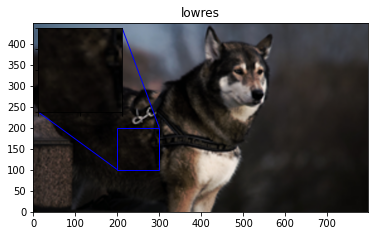

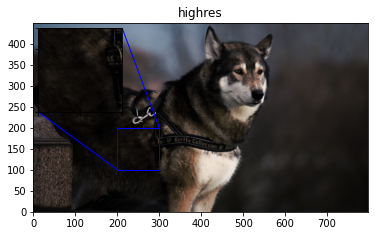

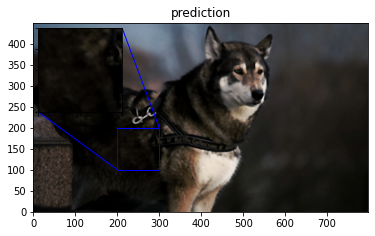

PSNR of low resolution image and high resolution image is 24.9010
PSNR of predict and high resolution is 25.5712


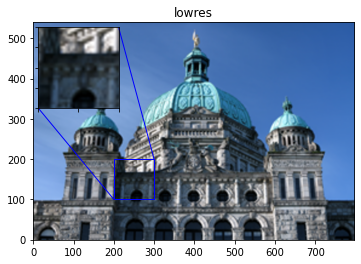

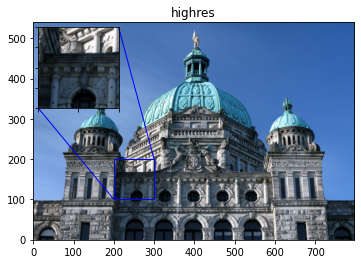

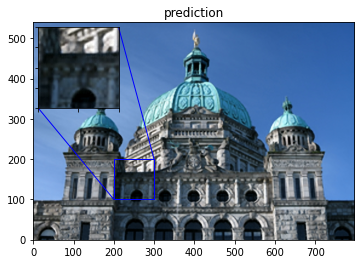

PSNR of low resolution image and high resolution image is 32.3493
PSNR of predict and high resolution is 32.5892


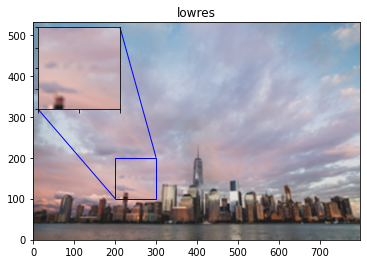

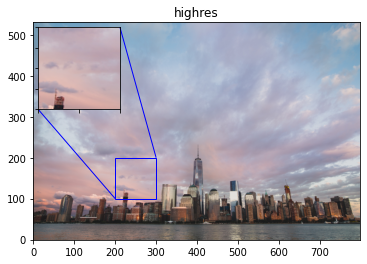

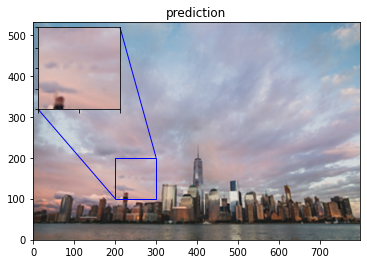

PSNR of low resolution image and high resolution image is 29.4402
PSNR of predict and high resolution is 30.6453


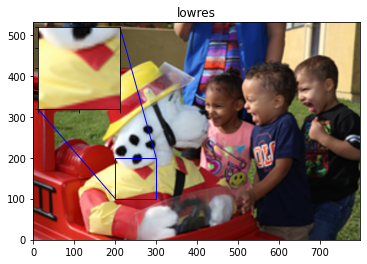

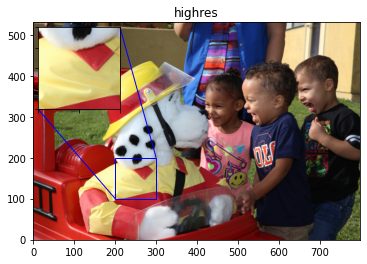

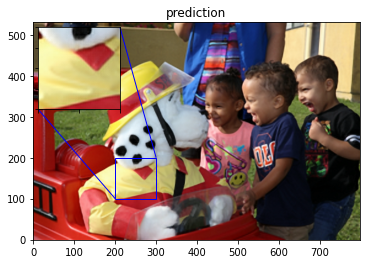

PSNR of low resolution image and high resolution image is 29.7395
PSNR of predict and high resolution is 30.1957


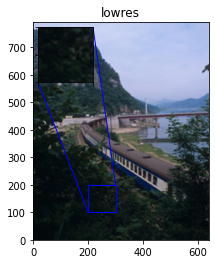

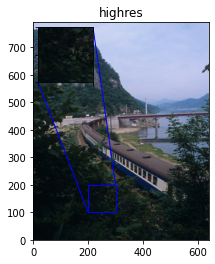

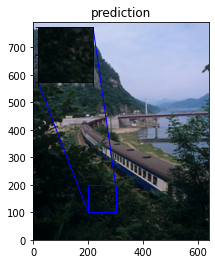

PSNR of low resolution image and high resolution image is 22.7958
PSNR of predict and high resolution is 23.5220


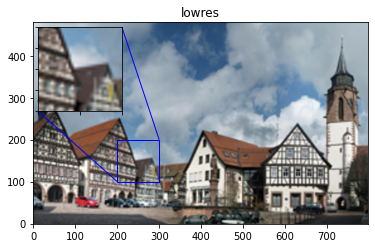

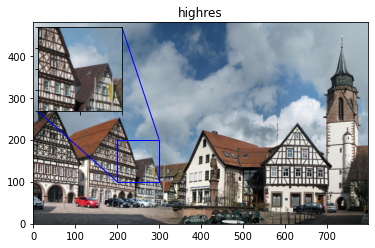

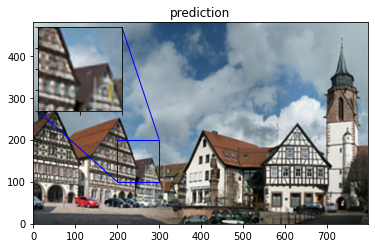

Avg. PSNR of lowres images is 27.3826
Avg. PSNR of reconstructions is 27.9086


In [ ]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

# Saving Batch Output

If this technique is needed to apply on batch photos in a folder.

In [ ]:
import glob

In [ ]:
#set an output directory
output_dir = "/content/drive/MyDrive/Project/DIV2Kpc/image/input/"

In [ ]:
#taking paths of all ground truth
paths= glob.glob(dataset_url+"/*") 

In [ ]:
#iterate over all images and save predicted images
for path in paths:
    img = load_img(path)
    low_res = get_lowres_image(img, upscale_factor=upscale_factor)
    predict = upscale_image(model, low_res)
    filepath = output_dir + os.path.basename(path)
    predict.save(filepath)
    

References: 
1. https://keras.io/examples/vision/super_resolution_sub_pixel/